In [24]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from hydra import initialize, compose
from rdkit import Chem
from ergochemics.draw import draw_reaction, draw_molecule
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import SVG
from tqdm import tqdm
from minedatabase.pickaxe import Pickaxe

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

In [25]:
expansion_name = "2_steps_250728_benchmark_starters_aplusb_True"
cpd_df = pd.read_parquet(Path(cfg.processed_data) / f"{expansion_name}_compound_metrics.parquet")
cpd_df = cpd_df.groupby(["expansion", "gen"]).agg({"fan_out": ["mean", "std"]}).reset_index()
cpd_df.head(24)

expansion gen     fan_out  \
                                                                 mean   
0   2_steps_250728_benchmark_starters_rules_mechin...   0  113.000000   
1   2_steps_250728_benchmark_starters_rules_mechin...   1   36.695733   
2   2_steps_250728_benchmark_starters_rules_mechin...   0  164.761905   
3   2_steps_250728_benchmark_starters_rules_mechin...   1   46.095599   
4   2_steps_250728_benchmark_starters_rules_mechin...   0  291.428571   
5   2_steps_250728_benchmark_starters_rules_mechin...   1   73.336303   
6   2_steps_250728_benchmark_starters_rules_mechin...   0  528.380952   
7   2_steps_250728_benchmark_starters_rules_mechin...   1   98.545153   
8   2_steps_250728_benchmark_starters_rules_mechin...   0  820.238095   
9   2_steps_250728_benchmark_starters_rules_mechin...   1  161.956388   
10  2_steps_250728_benchmark_starters_rules_mechin...   0  307.619048   
11  2_steps_250728_benchmark_starters_rules_mechin...   1   78.137500   
12  2_steps_250728_benchmark_starters_rules_rc_plu...   0  216.190476   
13  2_steps_250728_benchmark_starters_rules_rc_plu...   1   57.028205   
14  2_steps_250728_benchmark_starters_rules_rc_plu...   0   95.285714   
15  2_steps_250728_benchmark_starters_rules_rc_plu...   1   31.304094   
16  2_steps_250728_benchmark_starters_rules_rc_plu...   0   48.714286   
17  2_steps_250728_benchmark_starters_rules_rc_plu...   1   22.346535   
18  2_steps_250728_benchmark_starters_rules_rc_plu...   0   40.047619   
19  2_steps_250728_benchmark_starters_rules_rc_plu...   1   19.543478   

                 
            std  
0     66.388252  
1     25.166734  
2    158.383050  
3     30.171873  
4    348.090157  
5     43.068306  
6    723.182029  
7     60.952264  
8   1254.144685  
9    130.492589  
10   491.459711  
11    51.285660  
12   320.558360  
13    33.585623  
14   102.725432  
15    20.174365  
16    32.314305  
17    14.039070  
18    27.355943  
19    12.289126

In [26]:
known_reactions = {}

for exp_name in cpd_df["expansion"].unique():
    rule_set = exp_name.split("_rules_")[1]
    fn = Path(cfg.raw_data) / f"mapped_known_reactions_x_{rule_set}_rules.parquet"
    print(fn)
    mapped_rxns = pd.read_parquet(fn)
    rxns = set(mapped_rxns["smarts"])
    known_reactions[exp_name] = rxns

/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_01_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_02_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_04_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_13_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_91_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinformed_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_1_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_2_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_3_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_4_rules.parquet


In [27]:
rxn_df = pd.read_parquet(Path(cfg.processed_data) / f"{expansion_name}_reaction_metrics.parquet")
print(len(rxn_df))
rxn_df["known"] = rxn_df.apply(
    lambda row: row["smarts"] in known_reactions[row["expansion"]],
    axis=1
)
rxn_df = rxn_df[~rxn_df["known"]]
print(len(rxn_df))
rxn_df.head()

642533
634801


,id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion,known
0,Rb342395840e1257a62162ead2eb6a55efd37b3b357dce...,O=C(O)CCC(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=...,[O:1]=[C:2]([OH:3])[CH2:4][CH2:5][C:6](=[O:7])...,1,0.836046,*OC(=O)C(*)=O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O...,4151,[452_1],2_steps_250728_benchmark_starters_rules_mechin...,False
1,R3b13c2140a2fdc645a4458e189703590a28c7dbe77f09...,NC(N)=NCCCC(N)C(=O)O.NC(N)=NCCCC(N)C(=O)O>>NC(...,[NH2:1][C:2]([NH2:3])=[N:4][CH2:5][CH2:6][CH2:...,0,0.727607,N=C(N)NCCCC(N)C(=O)O.*C(=O)C(*)N>>*C(=O)C(*)NC...,435,"[822_0_1, 822_0_0, 822_0]",2_steps_250728_benchmark_starters_rules_mechin...,False
2,Rdfa93f07103aae10824d509d68aeea529a5ee0bb96534...,NC(N)=NCCCC(N)C(=O)O.NC(N)=NCCCC(N)C(=O)O>>NC(...,[NH2:1][C:2]([NH2:3])=[N:4][CH2:5][CH2:6][CH2:...,1,0.750000,N=C(N)NCCCC(N)C(=O)O.*C(=O)C(*)N>>*C(=O)C(*)NC...,435,"[822_0_1, 822_0_0, 822_0]",2_steps_250728_benchmark_starters_rules_mechin...,False
3,Ra026af274bc79ffff1660c0953f9fe76b7812bcad8391...,O=C(O)CCC(=O)O.NC(N)=NCCCC(N)C(=O)O>>NC(=NCCCC...,[O:1]=[C:2]([OH:3])[CH2:4][CH2:5][C:6](=[O:7])...,1,0.705882,O=C(O)CCC(=O)O.NC(CCC(=O)O)C(=O)O>>O=C(O)CCC(=...,24264,"[8_0, 8_0_0, 8_0_0_0]",2_steps_250728_benchmark_starters_rules_mechin...,False
4,R6b2c22e793f7c5b2d209912fa4078c9f0eff66014e556...,O=C(O)CCC(=O)O.NC(N)=NCCCC(N)C(=O)O>>NC(N)=NCC...,[O:1]=[C:2]([OH:3])[CH2:4][CH2:5][C:6](=[O:7])...,1,0.941176,O=C(O)CCC(=O)O.NC(CCC(=O)O)C(=O)O>>O=C(O)CCC(=...,24264,"[8_0, 8_0_0, 8_0_0_0]",2_steps_250728_benchmark_starters_rules_mechin...,False


In [28]:
rxn_df.groupby("expansion").agg({"dxgb_label": ["mean", "std"], "max_rxn_sim": ["mean", "std"]}).head(12)

dxgb_label            \
                                                         mean       std   
expansion                                                                 
2_steps_250728_benchmark_starters_rules_mechinf...   0.405003  0.490905   
2_steps_250728_benchmark_starters_rules_mechinf...   0.403908  0.490687   
2_steps_250728_benchmark_starters_rules_mechinf...   0.356065  0.478838   
2_steps_250728_benchmark_starters_rules_mechinf...   0.314478  0.464310   
2_steps_250728_benchmark_starters_rules_mechinf...   0.241384  0.427923   
2_steps_250728_benchmark_starters_rules_mechinf...   0.261647  0.439535   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.360685  0.480205   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.424454  0.494275   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.407085  0.491319   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.385190  0.486676   

                                                   max_rxn_sim            
                                                          mean       std  
expansion                                                                 
2_steps_250728_benchmark_starters_rules_mechinf...    0.779474  0.151096  
2_steps_250728_benchmark_starters_rules_mechinf...    0.771397  0.156046  
2_steps_250728_benchmark_starters_rules_mechinf...    0.748727  0.185535  
2_steps_250728_benchmark_starters_rules_mechinf...    0.719975  0.194842  
2_steps_250728_benchmark_starters_rules_mechinf...    0.637771  0.222440  
2_steps_250728_benchmark_starters_rules_mechinf...    0.757232  0.167326  
2_steps_250728_benchmark_starters_rules_rc_plus...    0.824416  0.122164  
2_steps_250728_benchmark_starters_rules_rc_plus...    0.871779  0.091600  
2_steps_250728_benchmark_starters_rules_rc_plus...    0.865223  0.096971  
2_steps_250728_benchmark_starters_rules_rc_plus...    0.847301  0.097057

In [31]:
ct_df = rxn_df.groupby("expansion").size().reset_index(name="n_rxns")
ct_df.head()

,expansion,n_rxns
0,2_steps_250728_benchmark_starters_rules_mechin...,19790
1,2_steps_250728_benchmark_starters_rules_mechin...,30554
2,2_steps_250728_benchmark_starters_rules_mechin...,66443
3,2_steps_250728_benchmark_starters_rules_mechin...,119859
4,2_steps_250728_benchmark_starters_rules_mechin...,265117


In [ ]:
exp_names = list(rxn_df.expansion.unique())
# perm = [0, 1, 6, 5, 4, 3, 2, 7, 8, 9, 10, 11]  # for plotting in order of increasing RC
# exp_names = [exp_names[p] for p in perm]
exp_labels = {
    '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': "Mechinformed",
    '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': "RC + 0",
    '2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': "RC + 1",
    '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': "RC + 2",
    '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': "RC + 3",
    '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': "RC + 4",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_91_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.91",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_13_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.13",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_04_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.04",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_02_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.02",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_01_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.01"
}

colors = {
    '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("green"),
    '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.3),
    '2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.45),
    '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.6),
    '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.85),
    '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=1.0),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_91_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.3),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_13_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.45),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_04_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.6),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_02_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.85),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_01_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=1.0)
}

legend_elements = [
    Patch(facecolor=col, edgecolor='w', label=exp_labels[name])
    for name, col in colors.items()
]

In [33]:
print(matplotlib.colors.to_rgba("blue"))
print(matplotlib.colors.to_rgba("purple"))
print(matplotlib.colors.to_rgba("black"))
print(matplotlib.colors.to_rgba("green"))

(0.0, 0.0, 1.0, 1.0)
(0.5019607843137255, 0.0, 0.5019607843137255, 1.0)
(0.0, 0.0, 0.0, 1.0)
(0.0, 0.5019607843137255, 0.0, 1.0)


IndexError: list index out of range

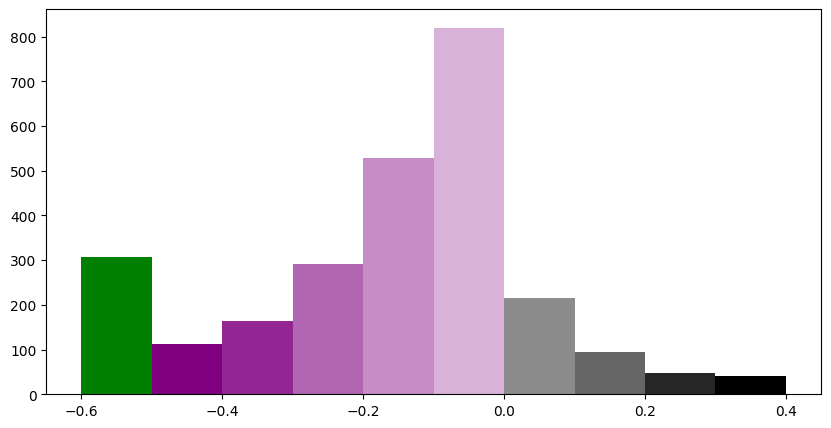

In [34]:
# Fan out clustered bar graph

gens = cpd_df.gen.unique()
scl_space = 1.5
n_bars = len(exp_labels)
width = 0.1

fig, ax = plt.subplots(figsize=(10, 5))

for gen in gens:
    ctr = gen * scl_space
    for i in range(n_bars):
        tick = ctr - ((n_bars * width) / 2) + (i * width)
        exp_name = exp_names[i]
        mean_fan_out = cpd_df.loc[(cpd_df["gen"] == gen) & (cpd_df["expansion"] == exp_name), "fan_out"]["mean"].values[0]
        label = exp_labels[exp_name]
        color = colors[exp_name]
        ax.bar(tick, height=mean_fan_out, width=width, color=color, label=label)
ax.set_xticks(gens * scl_space)
ax.set_xticklabels(gens.astype(int))

ax.set_xlabel("Generation")
ax.set_ylabel("Compound outdegree")
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_fan_out_clustered_bar_graph.svg", format="svg")
plt.show()
        

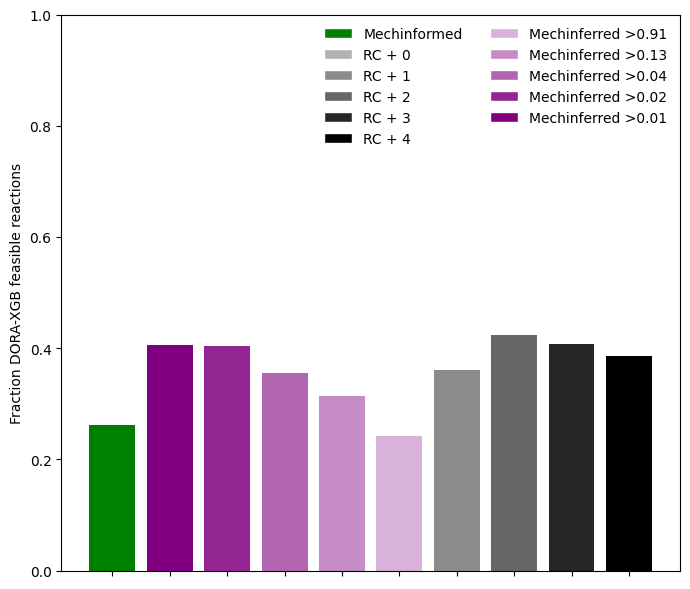

In [35]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    color = colors[exp_name]
    ax.bar(x=exp_name, height=feas_frac, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylim(0, 1.0)
ax.set_ylabel("Fraction DORA-XGB feasible reactions")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_feasibility_bar_graph.svg", format="svg")
plt.show()

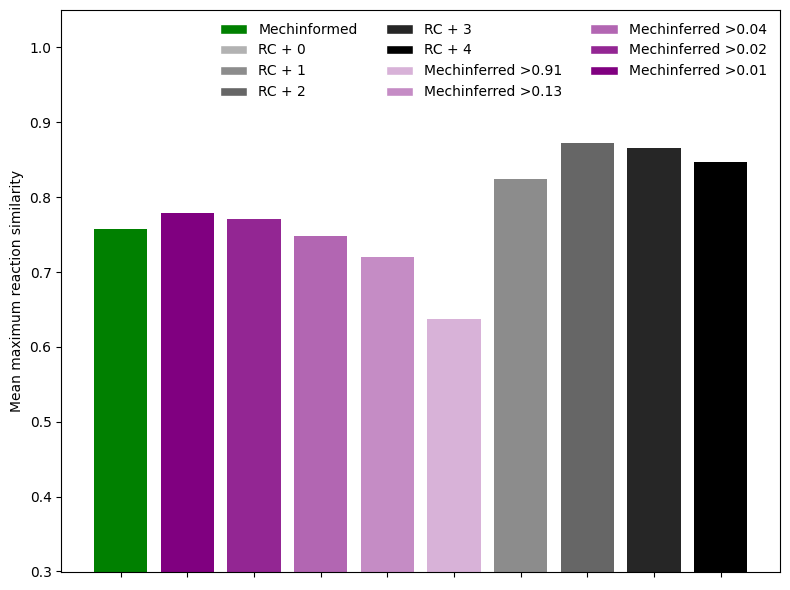

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.8
for exp_name in exp_names:
    mean = rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"].mean()
    color = colors[exp_name]
    ax.bar(x=exp_name, height=mean, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=3, frameon=False, fontsize=10)
ax.set_ylim(0.3, 1.05)
ax.set_ylabel("Mean maximum reaction similarity")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_max_rxn_sim_bar_graph.svg", format="svg")
plt.show()

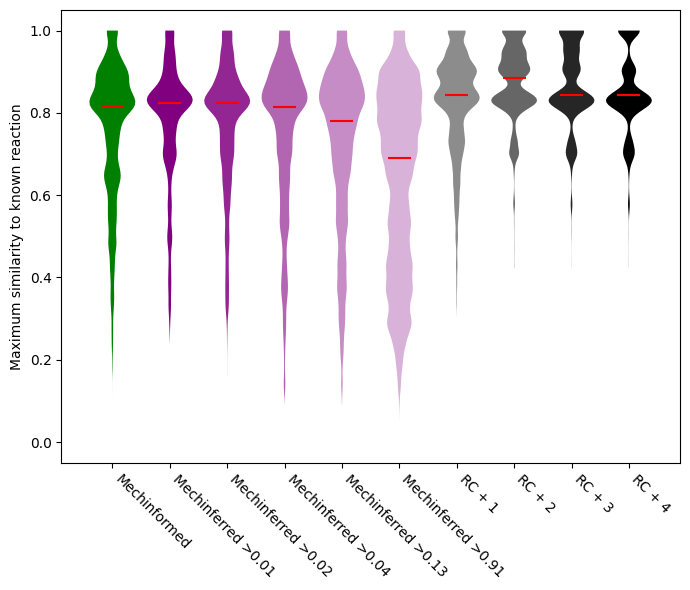

In [37]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
data = []
xticklabels = []
positions = []
_colors = []
_alphas = []
for i, exp_name in enumerate(exp_names):
    data.append(rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"])
    xticklabels.append(exp_labels[exp_name])
    positions.append(i)
    _colors.append(tuple(elt for elt in colors[exp_name][:-1]))
    _alphas.append(colors[exp_name][-1])  # store alpha for violin plot

vparts = ax.violinplot(data, positions=positions, widths=width, showmeans=False, showmedians=True, showextrema=False)

for color, alpha, vp in zip(_colors, _alphas, vparts['bodies']):
    vp.set_facecolor(color)
    # vp.set_edgecolor('black')
    vp.set_alpha(alpha)

vparts["cmedians"].set_color("red")

ax.set_xticks(positions)
ax.set_xticklabels(labels=xticklabels, rotation=-45, ha='left')
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel("Maximum similarity to known reaction")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_max_rxn_sim_violin_plot.svg", format="svg")
plt.show()

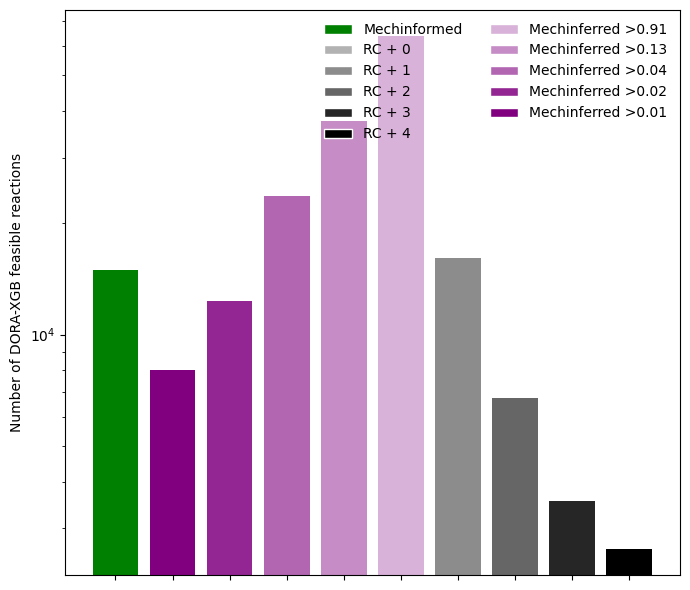

In [38]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    color = colors[exp_name]
    ax.bar(x=exp_name, height=feas_frac * tot_rxns, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Number of DORA-XGB feasible reactions")
ax.set_yscale('log')
plt.tight_layout()
plt.show()

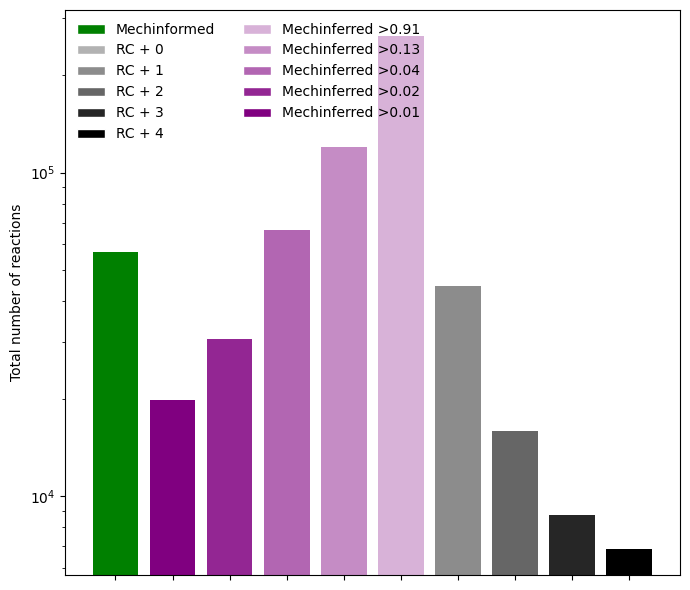

In [39]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    color = colors[exp_name]
    ax.bar(x=exp_name, height=tot_rxns, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper left', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_bar_graph.svg", format="svg")
plt.show()

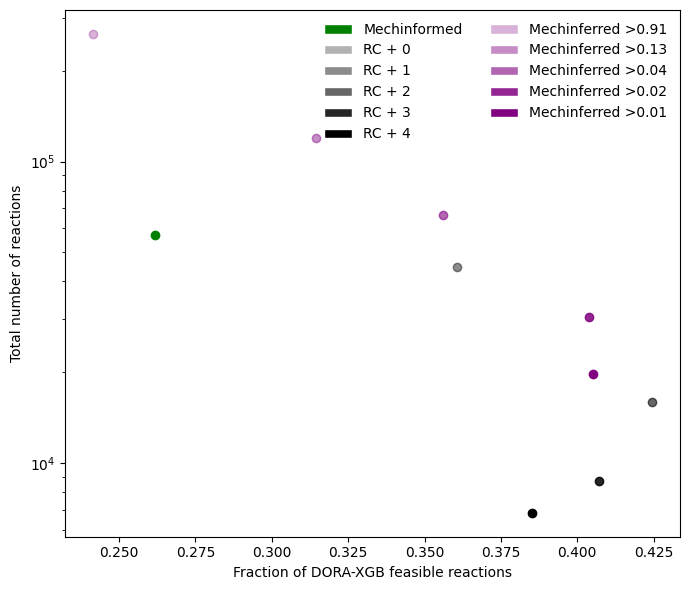

In [40]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    color = colors[exp_name]
    ax.plot(feas_frac, tot_rxns, marker='o', color=color)

ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_xlabel("Fraction of DORA-XGB feasible reactions")
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_vs_feasibility.svg", format="svg")
plt.show()

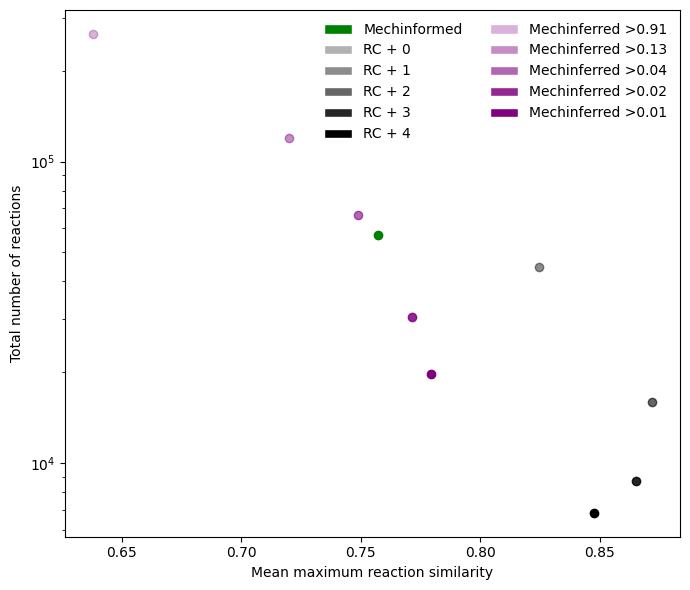

In [41]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    mean_max_sim = rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"].mean()
    color = colors[exp_name]
    ax.plot(mean_max_sim, tot_rxns, marker='o', color=color)

ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_xlabel("Mean maximum reaction similarity")
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_vs_mean_max_rxn_sim.svg", format="svg")
plt.show()

In [42]:
rxn_df.sort_values(by="max_rxn_sim", ascending=False)

,id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion,known
7617,R193d4a95b55a7c54f708f6ec78376a45af9b8ba36c542...,CC1(C)C2CCC1(C)C(OP(=O)(O)OP(=O)(O)O)C2.O=P(O)...,[CH3:1][C:2]1([CH3:3])[CH:4]2[CH2:5][CH2:6][C:...,0,1.000000,O=P(O)(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)...,26358,"[592_0, 1680_0]",2_steps_250728_benchmark_starters_rules_rc_plu...,False
7568,Ra57519f82871ef25ff318119a3b9956da676867789589...,CC(O)(CC(=O)O)CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(...,[CH3:1][C:2]([OH:3])([CH2:4][C:5](=[O:6])[OH:7...,0,1.000000,O=P(O)(O)OC1C(O)C(O)C(O)C(O)C1O.OCC(O)CO>>O.O=...,28445,"[12670_0_0, 12670_0]",2_steps_250728_benchmark_starters_rules_rc_plu...,False
9977,R7f7310ca47f2899fab316665fc48b8c2675a469ac3629...,CC(=O)O.O=C(CCO)OC1OC(CO)C(O)C(O)C1O>>CC(=O)OC...,[CH3:1][C:2](=[O:3])[OH:4].[O:5]=[C:6]([CH2:7]...,1,1.000000,CC(=O)O.OCC1OC(O)C(O)C(O)C1O>>CC(=O)OCC1OC(O)C...,7752,"[2770_0, 2770_0_0]",2_steps_250728_benchmark_starters_rules_rc_plu...,False
199510,R0f3318112b9e595b4f6abfa51f28f0b0a30b3daacdc5b...,C=C(OC1C=C(C(=O)OP(=O)(O)O)C=CC1O)C(=O)O.O>>CC...,[CH2:1]=[C:2]([O:3][CH:4]1[CH:5]=[C:6]([C:7](=...,1,1.000000,C=C(OC1C=C(C(=O)O)C=CC1O)C(=O)O.O>>CC(=O)C(=O)...,5480,[750_0],2_steps_250728_benchmark_starters_rules_mechin...,False
7553,R738e918fa919a4443ad32fb8621c6bf000724bec837f9...,C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)...,[CH3:1][S+:2]([CH2:3][CH2:4][CH:5]([NH2:6])[C:...,0,1.000000,C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)...,4340,[1782_1],2_steps_250728_benchmark_starters_rules_rc_plu...,False
...,...,...,...,...,...,...,...,...,...,...
29566,Rdfc0d84fe4658a5700f80d2e021fae20288d569d6d796...,O=C(O)C1(O)CC(O)C(O)C(C(O)CO)O1>>O=C(O)C(O)(O)...,[O:1]=[C:2]([OH:3])[C:4]1([OH:5])[CH2:6][CH:7]...,0,0.080000,*c1c(*)c(*)c(C2Oc3c(*)c(*)c(*)c(*)c3C(=O)C2*)c...,5027,[649_0],2_steps_250728_benchmark_starters_rules_mechin...,False
171433,R17be2d8bd24730d197c68ee2cab3200a725b04212a9f6...,C=C(OC1CC2(C(=O)O)C=CC1O2)C(=O)O>>C=C(OC1=CC=C...,[CH2:1]=[C:2]([O:3][CH:4]1[CH2:5][C:6]2([C:7](...,0,0.078446,*c1c(*)c(*)c(C2Oc3c(*)c(*)c(*)c(*)c3C(=O)C2*)c...,5027,[649_0],2_steps_250728_benchmark_starters_rules_mechin...,False
165221,R88af4fe1437a7cd433f88a8aa097b2abbd6a23b2cbb6a...,C=C(OC1C=C(C(=O)O)C2=CC1O2)C(=O)O>>C=C(Oc1ccc(...,[CH2:1]=[C:2]([O:3][CH:4]1[CH:5]=[C:6]([C:7](=...,0,0.071842,*c1c(*)c(*)c(C2Oc3c(*)c(*)c(*)c(*)c3C(=O)C2*)c...,5027,[649_0],2_steps_250728_benchmark_starters_rules_mechin...,False
165537,R6ae3c087c2225929a7e09e6e0bcd67af6f3de4d673119...,C=C(OC1C=C(C(=O)O)C=C2OC21)C(=O)O>>C=C(Oc1cc(O...,[CH2:1]=[C:2]([O:3][CH:4]1[CH:5]=[C:6]([C:7](=...,0,0.070711,*c1c(*)c(*)c(C2Oc3c(*)c(*)c(*)c(*)c3C(=O)C2*)c...,5027,[649_0],2_steps_250728_benchmark_starters_rules_mechin...,False


Venn diagrams

In [43]:
mechinfo_rids = rxn_df.loc[rxn_df["expansion"] == "2_steps_250728_benchmark_starters_mechinformed_rules_w_coreactants_aplusb_True.pk", "id"].values
mechinfo_rids = set(mechinfo_rids)
rc_plus_1_rids = rxn_df.loc[rxn_df["expansion"] == "2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk", "id"].values
rc_plus_1_rids = set(rc_plus_1_rids)

print(len(mechinfo_rids))
print(len(rc_plus_1_rids))

0
44690


In [44]:
mechinfo_only = mechinfo_rids - rc_plus_1_rids
print(len(mechinfo_only))
rc_info_only = rc_plus_1_rids - mechinfo_rids
print(len(rc_info_only))

mechinfo_rc_plus_1_intersect = mechinfo_rids & rc_plus_1_rids
print(len(mechinfo_rc_plus_1_intersect))

0
44690
0


In [45]:

pk = Pickaxe()
pk.load_pickled_pickaxe(Path(cfg.interim_data) / "2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk")

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk pickled data.


FileNotFoundError: [Errno 2] No such file or directory: '/home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk'

In [ ]:
starters = set()

for cid, cpd in pk.compounds.items():
    if cpd["Type"] == "Starting Compound":
        starters.add(cpd["SMILES"])

In [ ]:
mechinfo_only_df = rxn_df.loc[
    (rxn_df["expansion"] == "2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk") & (rxn_df["id"].isin(mechinfo_only))
]

mechinfo_only_df = mechinfo_only_df.sort_values(by=["dxgb_label", "max_rxn_sim"], ascending=False)
print(len(mechinfo_only_df))
mechinfo_only_df_first_gen = mechinfo_only_df.loc[mechinfo_only_df["smarts"].apply(lambda x: any([elt in starters for elt in x.split('>>')[0].split('.')]))].reset_index()
print(len(mechinfo_only_df_first_gen))
mechinfo_only_df_first_gen.head()

7852
2680


,index,id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion,known
0,97,Rc1d16b2f24a2c9ad05cf3eed4ffe2d1ac938d51a93a35...,CC(=O)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)...,[CH3:1][C:2](=[O:3])[C:4](=[O:5])[OH:6].[NH2:7...,1,1.000000,CC(=O)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)...,2779,[114_0],2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
1,2969,R5a5cc88637c00f9034e0d0cb68e94d1c5e24421ce4dba...,CC(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O...,[CH3:1][CH:2]([OH:3])[OH:4].[NH2:5][c:6]1[n:7]...,1,0.968750,O=P(O)(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)...,900,"[278_0_0, 278_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
2,4708,R8fa2d005dd0d1398abac63b6f657600ed6178a3b174cf...,NC(CC(=O)NP(=O)(O)O)C(=O)O.Nc1ncnc2c1ncn2C1OC(...,[NH2:1][CH:2]([CH2:3][C:4](=[O:5])[NH:6][P:7](...,1,0.939826,O=P(O)(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)...,900,"[278_0_0, 278_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
3,6584,R73501d6b2a750d208747db8d3a4afebdd3c89f9b21186...,CSCCC(NP(=O)(O)O)C(=O)O.Nc1ncnc2c1ncn2C1OC(COP...,[CH3:1][S:2][CH2:3][CH2:4][CH:5]([NH:6][P:7](=...,1,0.939826,O=P(O)(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)...,900,"[278_0_0, 278_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
4,8795,Ra4bc5932324f20abc7eddde141c0d4de72bed4e8cbdc6...,NC(CCCCNP(=O)(O)O)C(=O)O.Nc1ncnc2c1ncn2C1OC(CO...,[NH2:1][CH:2]([CH2:3][CH2:4][CH2:5][CH2:6][NH:...,1,0.939826,O=P(O)(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)...,900,"[278_0_0, 278_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False


In [ ]:
def show_rxn_info(idx):
    row = mechinfo_only_df_first_gen.iloc[idx]
    print(row["id"])
    print("Predicted:")
    display(SVG(draw_reaction(row["smarts"])))
    print("-" * 50)
    print("Nearest analogue:")
    display(SVG(draw_reaction(row["nearest_analogue"])))

srt_idx = mechinfo_only_df_first_gen.index
interact(show_rxn_info, idx=widgets.Dropdown(options=srt_idx, value=srt_idx[0]))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.show_rxn_info(idx)>

In [ ]:
rc1exp = Pickaxe()
rc1exp.load_pickled_pickaxe(Path(cfg.interim_data) / "2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk")

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk pickled data.
Loaded 5756 compounds
Loaded 9210 reactions
Loaded 3853 operators
Loaded 71 coreactants
Loaded 2 generation
Took 0.4062004089355469


[14:24:25] WARNING: not removing hydrogen atom without neighbors


In [ ]:
rc1exp.reactions['Rc1d16b2f24a2c9ad05cf3eed4ffe2d1ac938d51a93a35ed469e573297dea6da9']

KeyError: 'Rc1d16b2f24a2c9ad05cf3eed4ffe2d1ac938d51a93a35ed469e573297dea6da9'